In [229]:
# Tensorflow imports
from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [2]:
is_gpu_available()

True

### Connect to mongo database

In [3]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.external

In [259]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop('_id', 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

df['price_diff'] = df['price'].diff()
df = df.dropna()

df.head()

,n_tweets,price,sentiment,price_diff
timestamp,,,,
2017-08-02 06:00:00,892.0,2732.12,0.076942,-3.15
2017-08-02 07:00:00,830.0,2731.96,0.080092,-0.16
2017-08-02 08:00:00,819.0,2710.21,0.082844,-21.75
2017-08-02 09:00:00,1196.0,2719.31,0.087544,9.10
2017-08-02 10:00:00,1315.0,2732.99,0.061601,13.68


### Function to create timeline plot

In [200]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

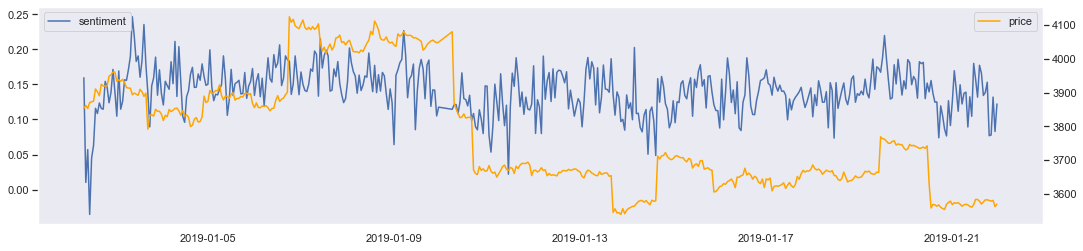

In [260]:
plot_timeline('sentiment', 'price')

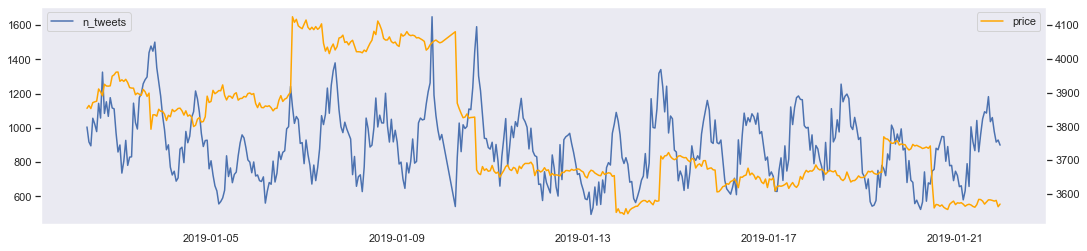

In [261]:
plot_timeline('n_tweets', 'price')

### Prepare training data

In [341]:
n_steps = 24
n_features = 3
train_size = int(.75 * len(df))

In [342]:
def split_sequence(sequence, n_steps, y_col=0):
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)

#### Train test split

In [343]:
prices = df['price'].values
prices_train, prices_test = prices[:train_size], prices[train_size:]

In [344]:
sentiment = df['sentiment'].values
sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]

In [345]:
n_tweets = df['n_tweets'].values
n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]

In [346]:
train = np.stack([prices_train, sentiment_train, n_tweets_train], axis=1)
test = np.stack([prices_test, sentiment_test, n_tweets_test], axis=1)

#### Scale the data

In [347]:
scaler = StandardScaler()

In [348]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

#### Generate sequences

In [349]:
X_train = split_sequence(train_scaled, n_steps)

In [350]:
X_test = split_sequence(test_scaled, n_steps)

In [351]:
# y_prices = (df['price']-df['price'].mean())/df['price'].std()
y_prices = df['price'].diff()

y_train = y_prices.iloc[n_steps:len(X_train)+n_steps].values
y_test = y_prices.iloc[-len(X_test):].values

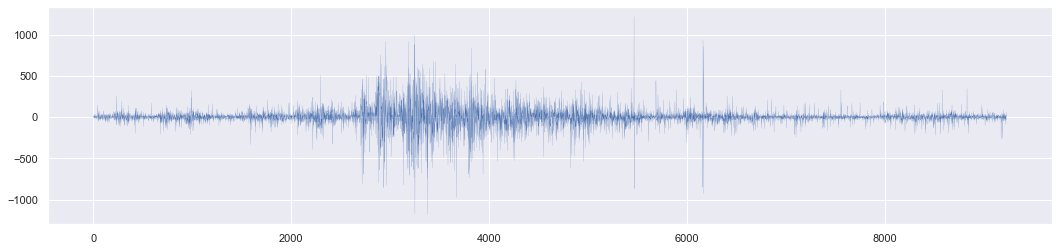

In [352]:
sns.set(style='darkgrid')
plt.plot(y_train, linewidth=.15);

In [353]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9228, 24, 3), (9228,), (3061, 24, 3), (3061,))

In [354]:
y_train

array([  5.71,   0.25,   7.14, ...,  58.43,  13.36, -26.49])

### Build the keras model

In [363]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_model(X, y):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
#     model.add(BatchNormalization())
    model.add(LSTM(32, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(.65))
#     model.add(Dense(41, activation='relu'))
# #     model.add(BatchNormalization())
#     model.add(Dropout(.43))
#     model.add(Dense(41, activation='relu'))
# #     model.add(BatchNormalization())
#     model.add(Dropout(.43))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    
    return model

In [364]:
# Create the model
model = build_model(X_train, y_train)

# Fit the model
model.fit(X_train, y_train, validation_split=0.2, epochs=32, batch_size=256);

Train on 7382 samples, validate on 1846 samples
Epoch 1/32
7382/7382 [==============================] - 6s 770us/sample - loss: 127.6268 - val_loss: 42.0600
Epoch 2/32
7382/7382 [==============================] - 4s 587us/sample - loss: 127.6191 - val_loss: 41.9439
Epoch 3/32
7382/7382 [==============================] - 4s 578us/sample - loss: 127.7644 - val_loss: 42.1113
Epoch 4/32
7382/7382 [==============================] - 4s 576us/sample - loss: 127.7154 - val_loss: 42.1081
Epoch 5/32
7382/7382 [==============================] - 4s 578us/sample - loss: 127.3481 - val_loss: 41.9540
Epoch 6/32
7382/7382 [==============================] - 4s 577us/sample - loss: 127.5095 - val_loss: 41.9355
Epoch 7/32
7382/7382 [==============================] - 4s 587us/sample - loss: 127.8160 - val_loss: 42.1124
Epoch 8/32
2560/7382 [=========>....................] - ETA: 2s - loss: 127.0309

KeyboardInterrupt: 

In [300]:
# Root mean squared error
'RMSE: ${:.2f}'.format(model.evaluate(X_test, y_test))

3061/3061 [==============================] - 3s 931us/sample - loss: 29.0274


'RMSE: $29.03'

In [301]:
# Predict using the test data
y_hat = model.predict(X_test)

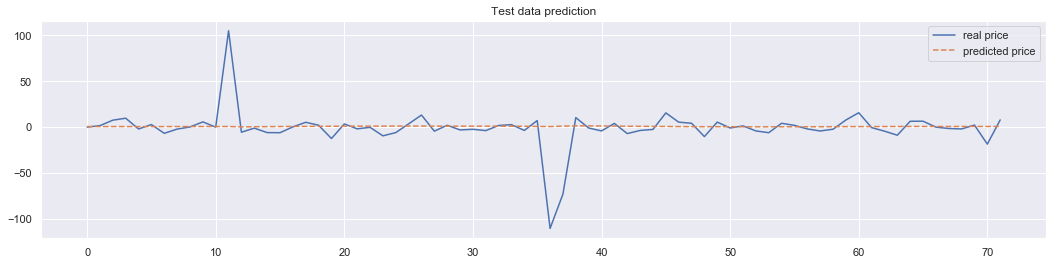

In [302]:
plt.plot(y_test[-72:], label='real price')
plt.plot(y_hat[-72:], linestyle='dashed', label='predicted price')
plt.title('Test data prediction')
plt.legend();

In [303]:
# Predict using the train data
y_hat_train = model.predict(X_train)

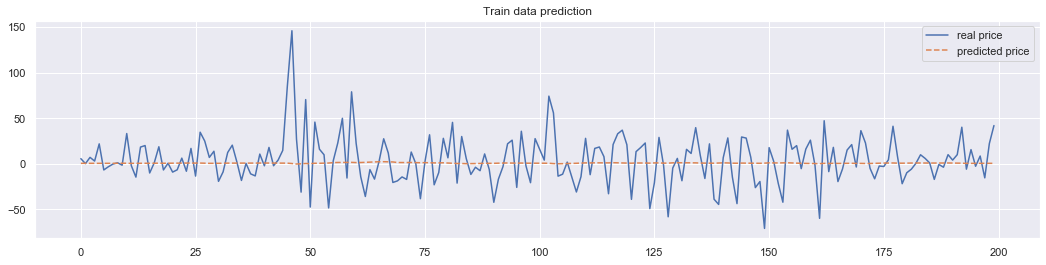

In [304]:
plt.plot(y_train[:200], label='real price')
plt.plot(y_hat_train[:200], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();